In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
import pickle

In [48]:
with open('Image_Data_256x256.pkl', 'rb') as file:
    data = pickle.load(file)

In [49]:
data.shape[0]

4000

In [50]:
bbox_folder = 'archive/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1'
bb_paths = glob(os.path.join(bbox_folder,'*.txt'))
len(bb_paths)

4000

In [51]:
path = "archive/Images - 1/Images - 1/"
image_paths = glob(os.path.join(path,'*.jpg'))

bbox_folder = 'archive/Bounding Boxes - YOLO Format - 1/Bounding Boxes - YOLO Format - 1'
bb_paths = glob(os.path.join(bbox_folder,'*.txt'))


Image_data = []
Label_data = []
Image_path = []

for i in bb_paths:
    if os.path.exists(i):
        if os.path.getsize(i) == 0:
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(cv2.bilateralFilter(data[bb_paths.index(i)], 9, 75, 75))
            Label_data.append('0')
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(cv2.GaussianBlur(data[bb_paths.index(i)], (5, 5), 0))
            Label_data.append('0') 
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(cv2.magnitude(cv2.Sobel(data[bb_paths.index(i)], cv2.CV_64F, 1, 0, ksize=3), cv2.Sobel(data[bb_paths.index(i)], cv2.CV_64F, 0, 1, ksize=3)))
            Label_data.append('0')
        else:
            k = np.random.randint(1, 4, 1)[0]
            Image_path.append(image_paths[bb_paths.index(i)])
            Image_data.append(cv2.GaussianBlur(data[bb_paths.index(i)], (5, 5), 0))
            Label_data.append('1')
                

In [52]:
df = pd.DataFrame({'Image': Image_data, 'Label': Label_data})

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   4776 non-null   object
 1   Label   4776 non-null   object
dtypes: object(2)
memory usage: 74.8+ KB


In [54]:
np.unique(df.Label, return_counts=True)

(array(['0', '1'], dtype=object), array([1164, 3612]))

## VGG19 Model

In [55]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Flatten, Dense, BatchNormalization

input_shape = (256, 256, 3)

vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in vgg19_model.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19_model)
model.add(Flatten())

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
Total params: 20024384 (76.39 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [56]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [57]:
Features = np.stack(df['Image'].values)
Target = np.stack(df['Label'].values)
x_train, x_test, y_train_o, y_test_o = train_test_split(Features, Target, test_size=0.2,random_state=666)
y_train = to_categorical(y_train_o, num_classes = 2)
y_test = to_categorical(y_test_o, num_classes = 2)

x_train = x_train.reshape(x_train.shape[0], *(256, 256, 3))
x_test = x_test.reshape(x_test.shape[0], *(256, 256, 3))

In [58]:
features = model.predict(x_train)
x_test_features = model.predict(x_test)

30/30 [==============================] - 104s 3s/step


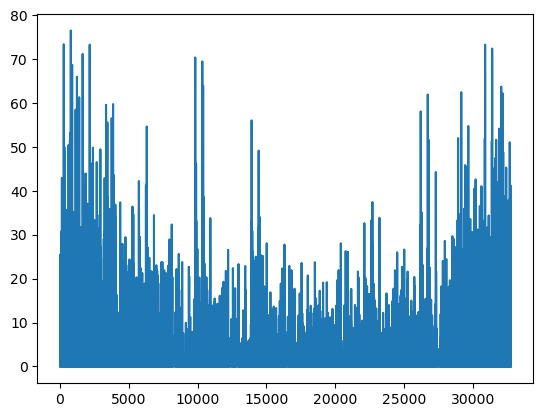

In [59]:
features = features.reshape((features.shape[0], -1))
x_test_features = x_test_features.reshape((x_test_features.shape[0], -1))
plt.plot(features[311])

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = scaler.fit_transform(features)
x_test_features = scaler.transform(x_test_features)

## KNN with VGG19 Features

In [61]:
# Model performace on Test Data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
knn_model = KNeighborsClassifier(n_neighbors=1) 
knn_model.fit(features, y_train)
y_pred = knn_model.predict(x_test_features)
print(accuracy_score(y_test, y_pred))
f1_score(y_test,y_pred,average="weighted")

0.8598326359832636


0.8478080251849256

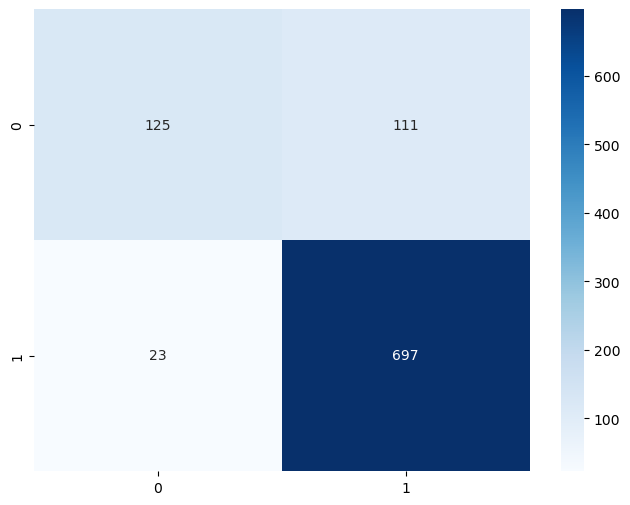

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## RF with VGG19 Features

In [63]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(features, y_train)
y_pred = random_forest_model.predict(x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

0.9131799163179917
0.9067512341286365


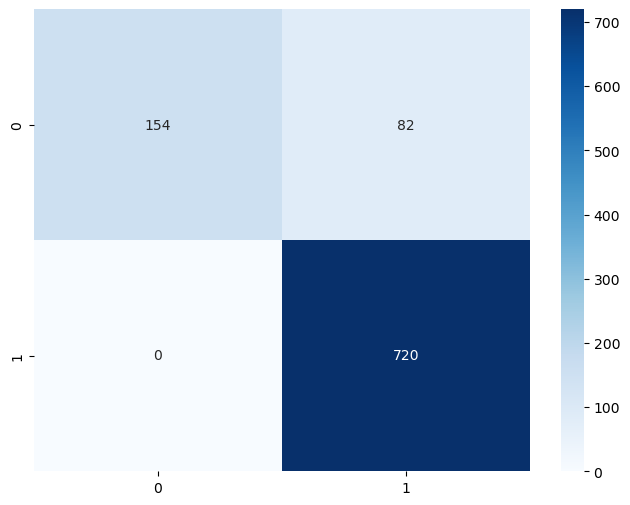

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## PCA - No use - Reducing Accuracy

In [65]:
# from sklearn.decomposition import PCA

# n_components = 1000

# pca = PCA(n_components=n_components)
# features_pca = pca.fit_transform(features)
# x_test_features_pca = pca.fit_transform(x_test_features)

In [66]:
# knn_model = KNeighborsClassifier(n_neighbors=1) 
# knn_model.fit(features_pca, y_train)
# y_pred = knn_model.predict(x_test_features_pca)
# print(accuracy_score(y_test, y_pred))
# print(f1_score(y_test,y_pred,average="weighted"))

In [67]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.show()

## Kernal PCA - No use - Reducing accuracy

In [68]:
# from sklearn.decomposition import KernelPCA

# n_components = 200
# kpca = KernelPCA(n_components=n_components, kernel='rbf', gamma=0.1)

# features_kpca = pca.fit_transform(features)
# x_test_features_kpca = pca.fit_transform(x_test_features)

In [69]:
# plt.plot(features_pca[2],label = "PCA")
# plt.plot(features_kpca[2],label = "Kernal-PCA")
# plt.legend()

In [70]:
# knn_model = KNeighborsClassifier(n_neighbors=1) 
# knn_model.fit(features_kpca, y_train)
# y_pred = knn_model.predict(x_test_features_kpca)
# print(accuracy_score(y_test, y_pred))
# print(f1_score(y_test,y_pred,average="weighted"))

In [71]:
# from sklearn.ensemble import RandomForestClassifier

# random_forest_model = RandomForestClassifier(n_estimators=100, random_state=43)
# random_forest_model.fit(features_kpca, y_train)

# y_pred = random_forest_model.predict(x_test_features_kpca)
# print(accuracy_score(y_test, y_pred))
# print(f1_score(y_test,y_pred,average="weighted"))

In [72]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.show()

## Lasso Feature Selection

In [73]:
from sklearn.linear_model import Lasso

alpha = 0.05 ## Increasing makes more features sparse
lasso_model = Lasso(alpha=alpha)
lasso_model.fit(features, y_train)
klp = lasso_model.predict(x_test_features)

In [74]:
Lasso_features = []
for i in features:
    Lasso_features.append(np.array(i[lasso_model.coef_[0] != 0]))
Lasso_features = np.array(Lasso_features)

Lasso_x_test_features = []
for i in x_test_features:
    Lasso_x_test_features.append(np.array(i[lasso_model.coef_[0] != 0]))
Lasso_x_test_features = np.array(Lasso_x_test_features)

In [75]:
knn_model = KNeighborsClassifier(n_neighbors=11) 
knn_model.fit(Lasso_features, y_train)
y_pred = knn_model.predict(Lasso_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

0.9131799163179917
0.906283366992636


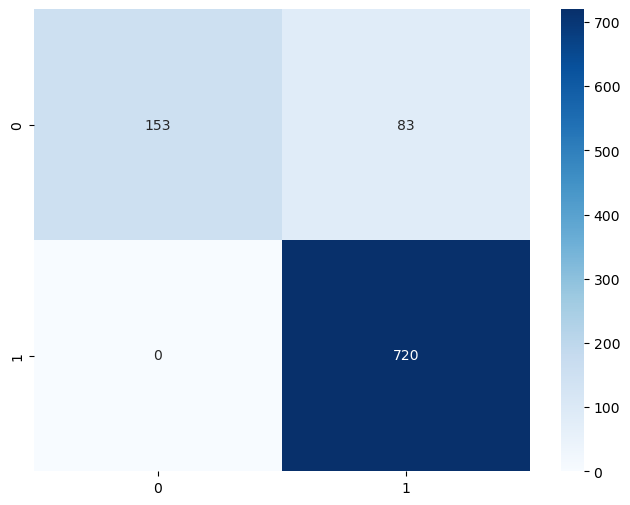

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [77]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=43)
random_forest_model.fit(Lasso_features, y_train)

y_pred = random_forest_model.predict(Lasso_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

0.9152719665271967
0.9087518610442261


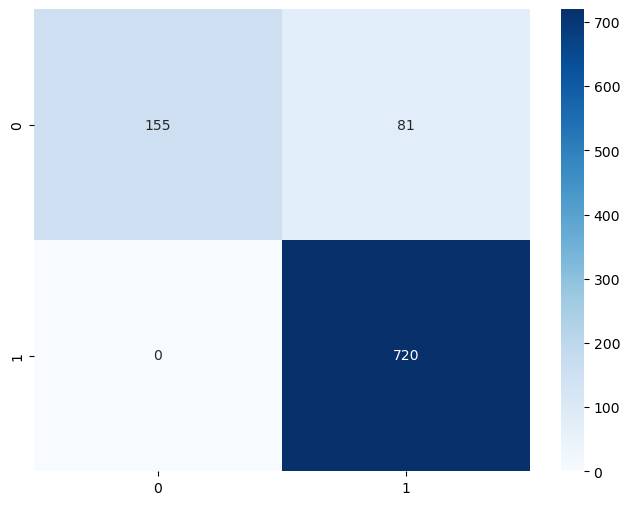

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## ElasticNet Features

In [79]:
from sklearn.linear_model import ElasticNet
alpha = 0.05
l1_ratio = 0.5

elastic_net_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
elastic_net_model.fit(features, y_train)

ElasticNet(alpha=0.05)

In [80]:
EN_features = []
for i in features:
    EN_features.append(np.array(i[elastic_net_model.coef_[0] != 0]))
EN_features = np.array(EN_features)

EN_x_test_features = []
for i in x_test_features:
    EN_x_test_features.append(np.array(i[elastic_net_model.coef_[0] != 0]))
EN_x_test_features = np.array(EN_x_test_features)

In [81]:
knn_model = KNeighborsClassifier(n_neighbors=13) 
knn_model.fit(EN_features, y_train)
y_pred = knn_model.predict(EN_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

0.9121338912133892
0.9050441183313459


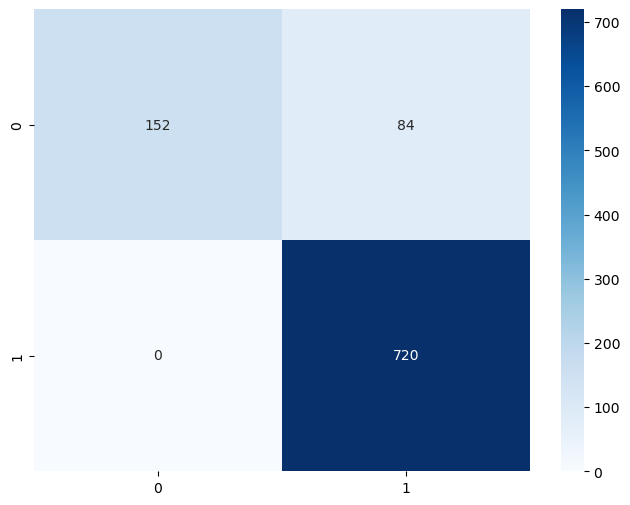

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [83]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=43)
random_forest_model.fit(EN_features, y_train)

y_pred = random_forest_model.predict(EN_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

0.9152719665271967
0.9087518610442261


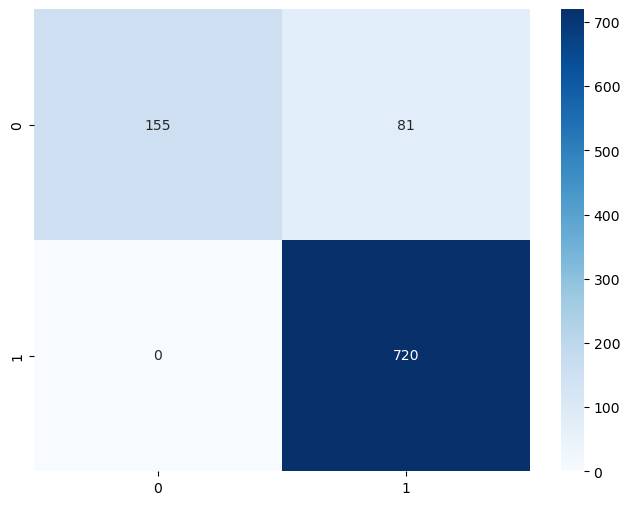

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## Convex Optimization - Proximal Gradient method

In [85]:
from scipy.optimize import minimize

def objective_function(x, A, b, lambd):
    return 0.5 * np.linalg.norm(A @ x - b)**2 + lambd * np.linalg.norm(x, 1)

def proximal_gradient_descent_scipy(A, b, lambd, x0, max_iter=10, tol=1e-4):
    result = minimize(
        fun=objective_function,
        x0=x0,
        args=(A, b, lambd),
        method='L-BFGS-B',  
        options={'maxiter': max_iter, 'disp': True}
    )

    return result.x

A = np.matrix(Lasso_features)
b = np.matrix(np.argmax(y_train, axis=1))

resulting_coefficients = proximal_gradient_descent_scipy(A, b, lambd=0.01, x0=np.zeros(A.shape[1]))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44600D+03    |proj g|=  8.26073D+02

At iterate    1    f=  1.26895D+03    |proj g|=  1.91129D+02

At iterate    2    f=  1.26550D+03    |proj g|=  1.58809D+02

At iterate    3    f=  1.25713D+03    |proj g|=  2.34178D+01

At iterate    4    f=  1.25679D+03    |proj g|=  1.45718D+01

At iterate    5    f=  1.25647D+03    |proj g|=  4.27663D+00

At iterate    6    f=  1.25645D+03    |proj g|=  3.68627D+00

At iterate    7    f=  1.25644D+03    |proj g|=  1.90169D+00

At iterate    8    f=  1.25644D+03    |proj g|=  1.41979D+00

At iterate    9    f=  1.25643D+03    |proj g|=  1.38737D+00

At iterate   10    f=  1.25643D+03    |proj g|=  1.38284D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


In [93]:
rc = np.round(resulting_coefficients,4)
sum(rc!=0)

32

In [94]:
PGD_features = []
for i in Lasso_features:
    PGD_features.append(np.array(i[rc != 0]))
PGD_features = np.array(PGD_features)


PGD_x_test_features = []
for i in Lasso_x_test_features:
    PGD_x_test_features.append(np.array(i[rc != 0]))
PGD_x_test_features = np.array(PGD_x_test_features)

In [98]:
knn_model = KNeighborsClassifier(n_neighbors=15) 
knn_model.fit(PGD_features, y_train)
y_pred = knn_model.predict(PGD_x_test_features)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test,y_pred,average="weighted"))

0.9131799163179917
0.906283366992636


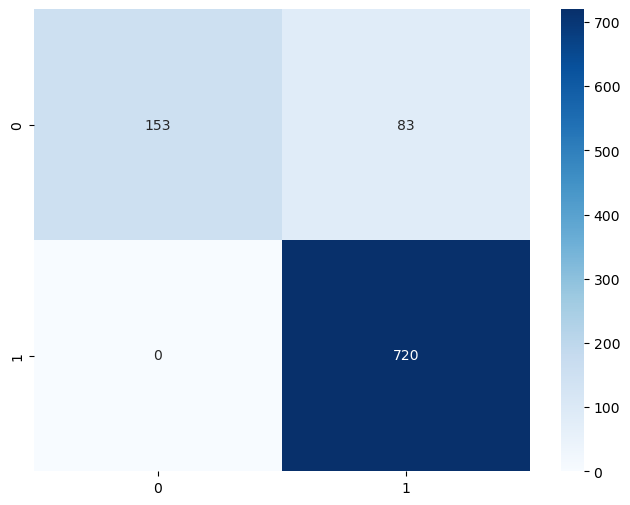

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [90]:
# from sklearn.ensemble import RandomForestClassifier

# random_forest_model = RandomForestClassifier(n_estimators=100, random_state=43)
# random_forest_model.fit(PGD_features, y_train)

# y_pred = random_forest_model.predict(PGD_x_test_features)
# print(accuracy_score(y_test, y_pred))
# print(f1_score(y_test,y_pred,average="weighted"))

In [91]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


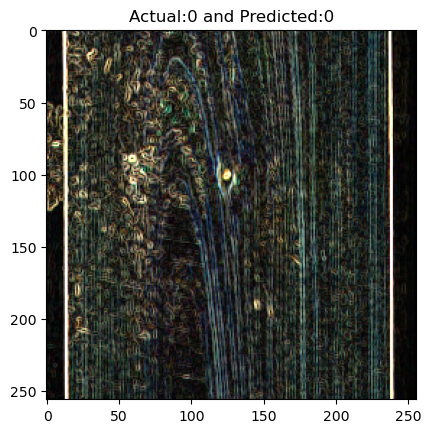

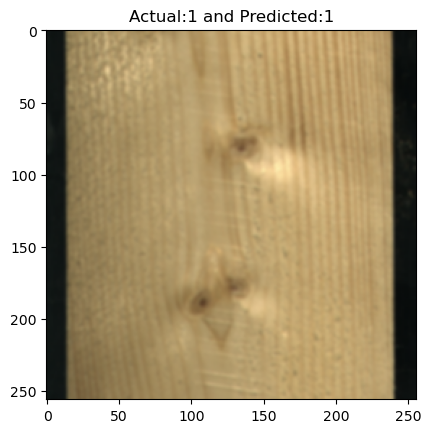

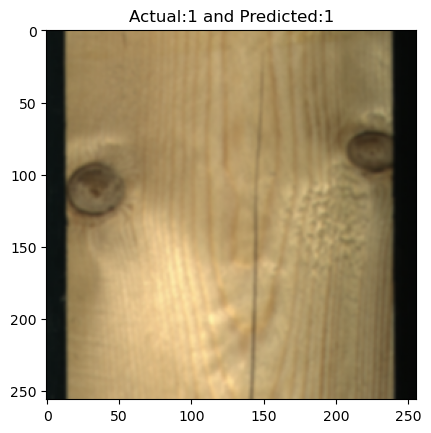

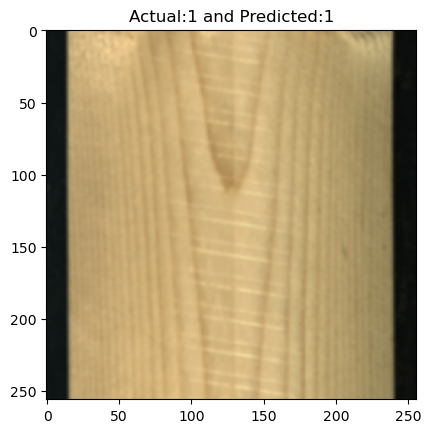

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


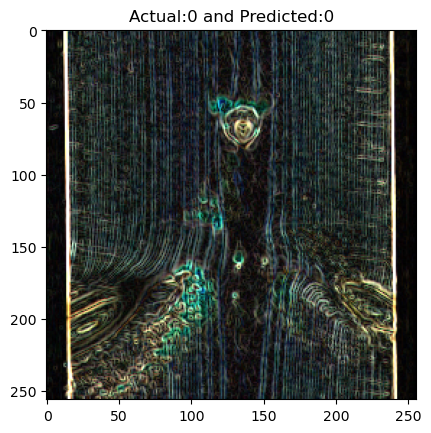

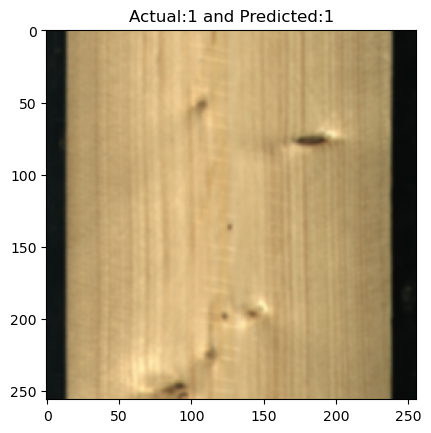

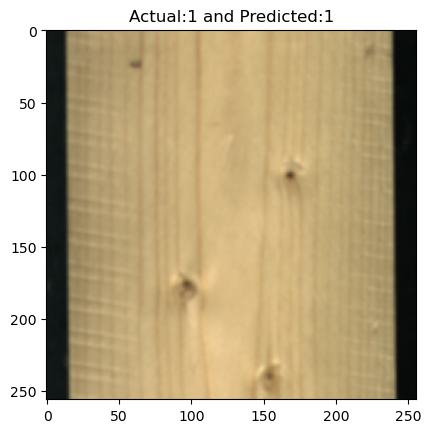

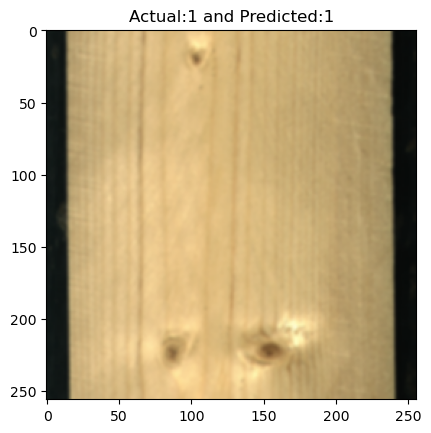

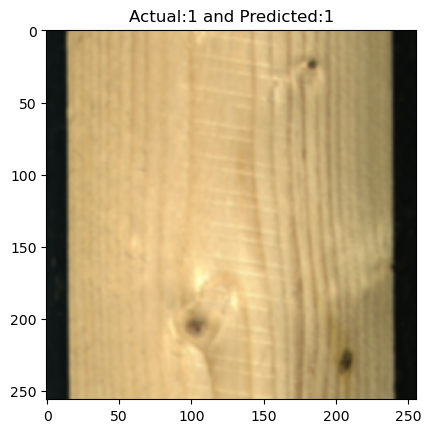

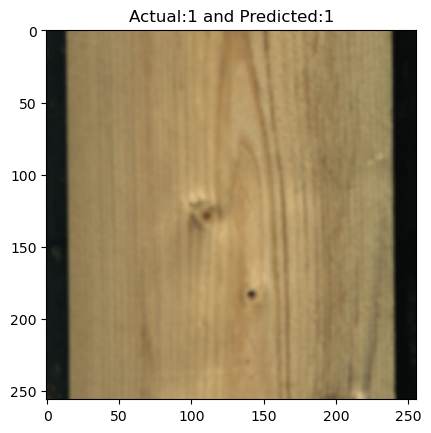

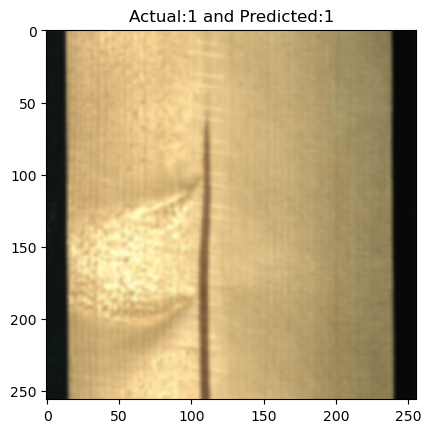

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


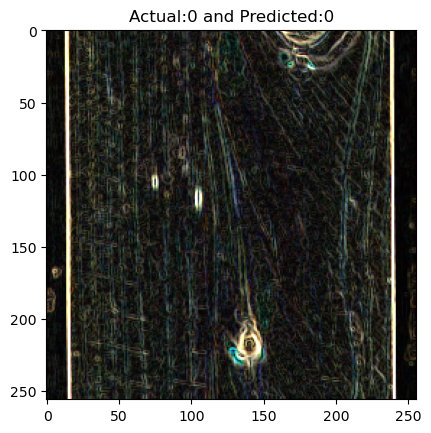

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


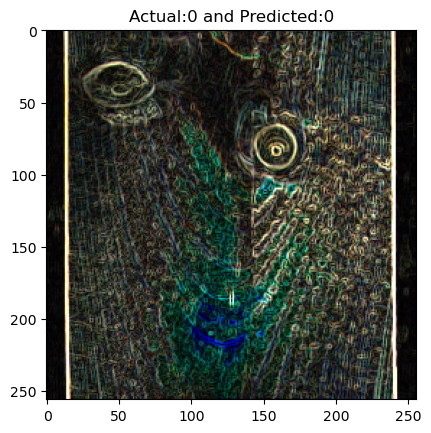

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


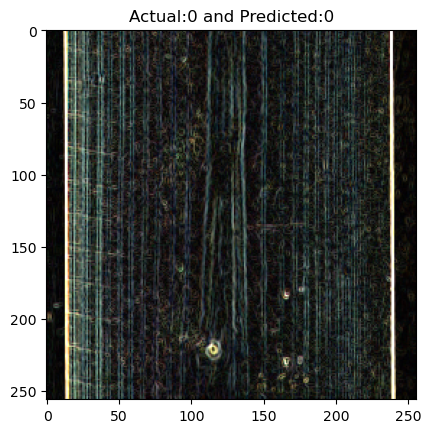

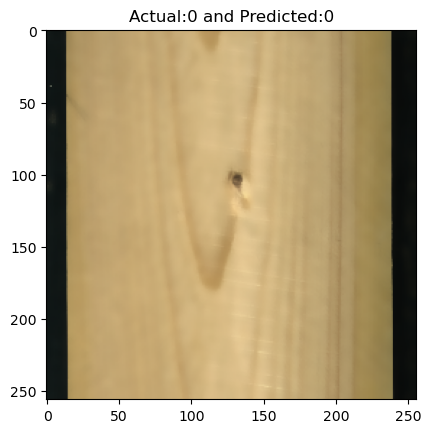

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


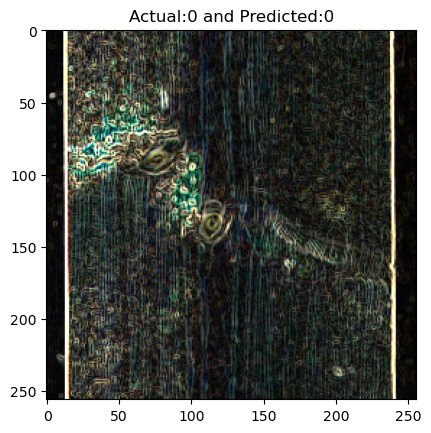

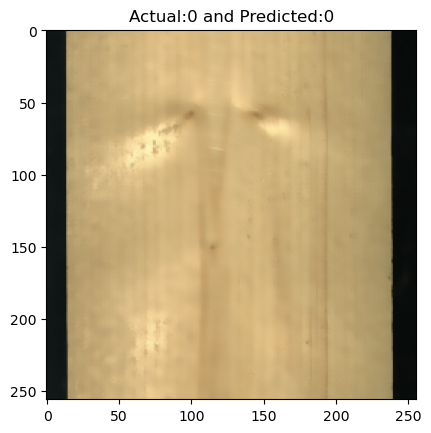

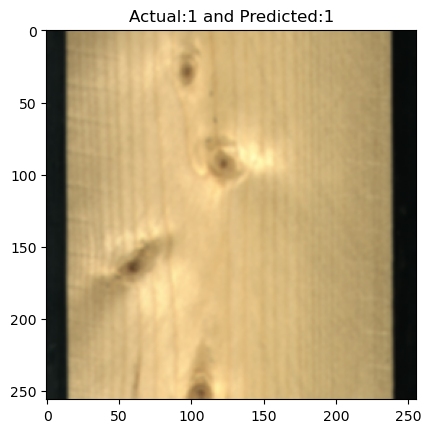

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


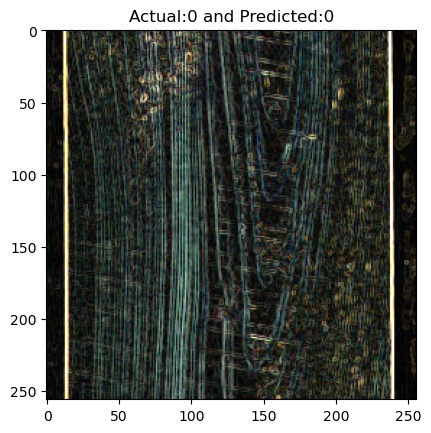

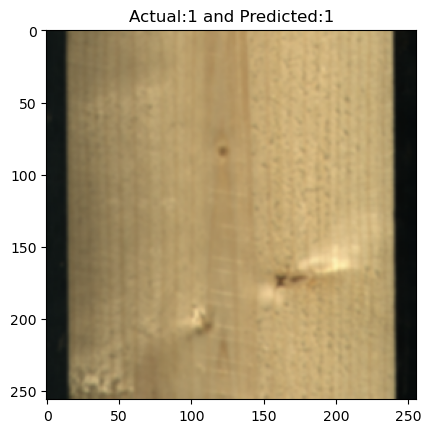

In [92]:
yt = np.argmax(y_test, axis=1)
yp = np.argmax(y_pred, axis=1)
k = np.random.randint(1, len(y_test), size=20)
for i in k:
    plt.imshow(x_test[i]/255)
    plt.title(f'Actual:{yt[i]} and Predicted:{yp[i]}')
    plt.show()